# 1. 패키지, 모듈, 클래스, 함수 불러오기

In [ ]:
# # klib , missingno 패키지 (EDA 패키지)
# !pip install klib
# !pip install missingno

# # pycaret 패키지
# !pip install -upgrade matplotlib pandas seaborn tqdm requests
# # !pip install pycaret
# !pip install shap awscli azure-storage-blob google-cloud-storage psutil

# # 베이지안 최적화 optuna 패키지
# # !pip install optuna

# # catboost 모델 패키지
# !pip install catboost

# # # tensorflow 패키지
# !pip install tensorflow

# # # shap 패키지
# !pip install shap

# # # 이미지 처리 패키지
# # !install Pillow

# # !pip install pydot
# !pip install -q -U keras-tuner

In [ ]:
# Data Wrangling
import pandas as pd
import numpy as np
import pandas_profiling as pp
import gc

# Visualization, EDA
import missingno as msno
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Korean font
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# import optuna

# Modeling
from lightgbm import LGBMClassifier
# from pycaret.classification import *
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import *
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from keras.callbacks import ModelCheckpoint

# Utility
import re
import os
import time
import datetime
import random
import tensorflow as tf
import pickle
import joblib
import platform
import warnings; warnings.filterwarnings("ignore")
from itertools import combinations
from tqdm import tqdm, tqdm_notebook
from IPython.display import Image
from scipy.stats.mstats import gmean
from tensorflow import keras
from PIL import Image

In [ ]:
# 코랩에서만 경로 설정
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive/ML Competition/input"

# panel = pd.read_csv(path + '/panel.csv', encoding = "utf-8")
# survey = pd.read_csv(path + '/survey.csv', encoding = "utf-8")
# response_train = pd.read_csv(path + '/response_train.csv', encoding = "utf-8")
# response_test = pd.read_csv(path + '/response_test.csv', encoding = "utf-8")
# sub = pd.read_csv(path + "/sample_submission.csv")

Mounted at /content/drive


# 2. 데이터 불러오기

In [ ]:
# 주피터 파일일때(주석처리)
panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')
survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv')


# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)
# REGION 컬럼 무의미해서 drop
panel.drop(['REGION'], axis=1, inplace=True)

# 3. Feature Create

##### (패널 질문 응답수)

In [ ]:
# 패널 질문 COUNT(질문의 성의 판단)
panel_Questions = panel.iloc[:,4:]

panel = panel.iloc[:,:4]
panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

# 패널 질문 응답수
panel['Questions_count'] = panel_Questions_count

train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')


# train 데이터 분할 [seeddeep (inputp1.5mean_submission_1214_0337.csv)]
before_train = train.query("TIME<='2021-02-01 00:00:00'")
train = train.query("TIME>='2021-02-01 00:00:00'")

# train 데이터 분할 [newseeddeep (inputp1.5mean_submission_1215_0240.csv)
# before_train = train.query("TIME<='2021-02-20 00:00:00'")
# train = train.query("TIME>='2021-02-20 00:00:00'")



##### (패널 ID별 누적 포인트)

In [ ]:
# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
train = train.merge(Points_earned_mean, how='left')

train['Points_earned'].fillna(0, inplace = True)#여기바뀜
train['Points_earned_mean'].fillna(0, inplace = True)#여기바뀜

test = test.merge(Points_earned, how='left')
test = test.merge(Points_earned_mean, how='left')

test['Points_earned'].fillna(0, inplace = True) #여기바뀜
test['Points_earned_mean'].fillna(0, inplace = True)#여기바뀜

##### (일자, 요일, 시간 처리)

In [ ]:
data = [train, test]

for i in data:
    i['TIME'] = i['TIME'].astype("datetime64")
    
    i['DAY'] = i['TIME'].dt.day

    i["MONTH"] = i["TIME"].dt.month
    
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    
    i['HOUR'] = i['TIME'].dt.hour


##### (TITLE/ CATEGORIES 빈도수)

In [ ]:
# [^ ㄱ-ㅣ가-힣] 정규 표현식
# 다소 시간이 오래 걸림
word_counts = {}
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x):
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [ ]:
train["CATEGORIES_CNT"]=0
test["CATEGORIES_CNT"]=0

train["CATEGORIES"]=train["CATEGORIES"].fillna("unknown")
test["CATEGORIES"]=test["CATEGORIES"].fillna("unknown")
word_counts = {}
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x):
    score = 0
    for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.CATEGORIES_CNT = train.apply(score_word, axis=1)
test.CATEGORIES_CNT = test.apply(score_word, axis=1)

##### (IR 별 응답확률)

In [ ]:
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})
train = train.merge(train_IR,how='left')
test = test.merge(train_IR,how='left')
test.STATUS_ratio_IR=test.STATUS_ratio_IR.fillna(test.STATUS_ratio_IR.mean())

##### (LOI별 응답확률)

In [ ]:
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})
train = train.merge(train_LOI,how='left')
test = test.merge(train_LOI,how='left')
test.STATUS_ratio_LOI=test.STATUS_ratio_LOI.fillna(test.STATUS_ratio_LOI.mean())

##### (CPI 별 응답확률)

In [ ]:
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})
train = train.merge(train_CPI,how='left')
test = test.merge(train_CPI,how='left')
test.STATUS_ratio_CPI=test.STATUS_ratio_CPI.fillna(test.STATUS_ratio_CPI.mean())

##### (TYPE 별 응답확률)

In [ ]:
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

##### (유저 아이디 별 응답확률)

In [ ]:
respond = train.query('STATUS == 1').groupby('userID')['userID'].agg([('respond',np.size)]).reset_index()
total = train.groupby('userID')['userID'].agg([('total',np.size)]).reset_index()

train = train.merge(respond).merge(total)

train['Response_Probability'] = train['respond'] / train['total']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'Response_Probability']], how='left')
test['Response_Probability'] = test['Response_Probability'].fillna(0) 

del train['respond'], train['total']

##### (시간별 응답확률)

In [ ]:
hour_mean = train.groupby("HOUR").STATUS.mean()
train["STATUS_ratio_hour"] = train["HOUR"].map(dict(hour_mean))
test["STATUS_ratio_hour"] = test["HOUR"].map(dict(hour_mean))

##### (CATEGORIES 라벨인코딩)

In [ ]:
#Label Encoding
encoder = LabelEncoder()

# X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
encoder.fit(train["CATEGORIES"])
train_encoded_cat = encoder.transform(train["CATEGORIES"])

# X_test데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가한다 
for label in np.unique(test["CATEGORIES"]):
    if label not in encoder.classes_: # unseen label 데이터인 경우( )
        encoder.classes_ = np.append(encoder.classes_, label) # 미처리 시 ValueError발생
test_encoded_cat = encoder.transform(test["CATEGORIES"])

train["CATEGORIES"] = pd.DataFrame(train_encoded_cat)
test["CATEGORIES"] = pd.DataFrame(test_encoded_cat)

del train_encoded_cat, test_encoded_cat

##### (시간별 응답확률)

In [ ]:
weekday_mean = train.groupby("WEEKDAY").STATUS.mean()
train["weekday_mean"] = train["WEEKDAY"].map(dict(weekday_mean))
test["weekday_mean"] = test["WEEKDAY"].map(dict(weekday_mean))

##### (성별응답확률)

In [ ]:
res_freq = train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('g_i','mean')]).reset_index()
train = pd.merge(train, res_freq, how='left')
test = pd.merge(test, res_freq, how='left')
test.FREQ = test.g_i.fillna(test.g_i.mean())

###### (생년 -> 나이)

In [ ]:
train["AGE"] = 2022- train["BIRTH"]
test["AGE"] = 2022- test["BIRTH"]

# 4. Feature Engineering

##### 무의미한 feature 삭제

In [ ]:
y_train = train['STATUS']
train.drop(['STATUS','userID', 'surveyID', 'TIME',"BIRTH"], axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop(['ID','userID', 'surveyID', 'TIME',"BIRTH"], axis=1, inplace=True)

##### Feature 전처리

In [ ]:
# train, test 병합 후 결측값 처리
features = pd.concat([train, test]).reset_index(drop=True)

features = features.astype({'GENDER':'object'})

cat = features.select_dtypes(include=['object','category']).columns.to_list()# 범주형 변수
num = features.select_dtypes(exclude=['object','category']).columns.to_list()# 수치형 변수

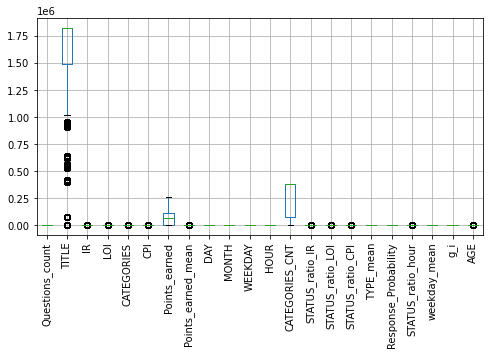

In [ ]:
# 이상치 제거 전 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

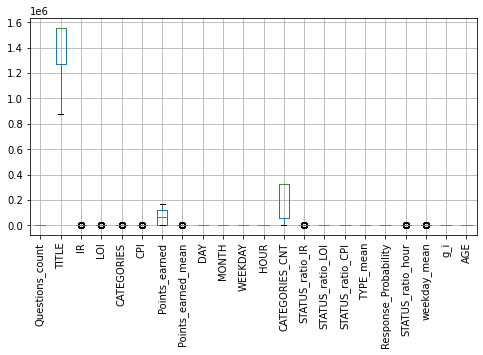

In [ ]:
# 수치형 변수 이상치 제거
features[num] = features[num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 이상치 제거 후 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

In [ ]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

# 스케일링 전 train, test 분할
X_train = features.iloc[:y_train.shape[0], :]
X_test = features.iloc[y_train.shape[0]:, :]

scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [ ]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

# 5. 피쳐 셀렉션

In [ ]:
# Method: Using SHAP values 
import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_test

# # Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
17,Response_Probability,2.45338
15,STATUS_ratio_CPI,0.452758
18,STATUS_ratio_hour,0.196471
1,TITLE,0.121699
9,MONTH,0.100185
10,WEEKDAY,0.0831565
8,DAY,0.0782434
16,TYPE_mean,0.0569142
4,CATEGORIES,0.0538787
11,HOUR,0.048974


In [ ]:
# feature 중요도가 0.02 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(1005329, 23)


# 6.딥러닝 모델링

##### deeplearning을 위한 feature

In [ ]:
X_train.drop(columns = ["CATEGORIES_CNT","STATUS_ratio_LOI","STATUS_ratio_IR","Points_earned"],inplace=True)
X_test.drop(columns = ["CATEGORIES_CNT","STATUS_ratio_LOI","STATUS_ratio_IR","Points_earned"],inplace=True)

In [ ]:
# test size 올리기위해 0.4
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.4, random_state=77) 

##### seed ensemble

In [ ]:
# reset_seeds()함수를 아래와 같이 수정해야 함.
def reset_seeds(SEED, reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional

In [ ]:
# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

In [ ]:
for i in tqdm(range(20)):    
    SEED = np.random.randint(1, 10000)              
    reset_seeds(SEED)
    
    # Define the NN architecture
    input = keras.Input(shape=(X_train.shape[1],))
    x = keras.layers.Dense(32, activation='relu')(input)
    x = keras.layers.Dense(16, activation='relu')(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(input, output)    

    # Choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(lr=0.001), metrics=['acc', keras.metrics.AUC()])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), batch_size=4096, epochs=50, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    # Make submissions
    submission = pd.DataFrame({
        "ID": test_id["ID"], 
        "STATUS": model.predict(X_test).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/loop_submission_{t.month:02}{t.day:02}_{SEED:05}.csv"
    submission.to_csv(os.path.abspath("../submissions") + '/' + fname, index=False) 

  0%|          | 0/20 [00:00<?, ?it/s]

RANDOM SEEDS RESET


  5%|▌         | 1/20 [01:43<32:37, 103.01s/it]

RANDOM SEEDS RESET


 10%|█         | 2/20 [03:27<31:06, 103.72s/it]

RANDOM SEEDS RESET


 15%|█▌        | 3/20 [05:11<29:25, 103.87s/it]

RANDOM SEEDS RESET


 20%|██        | 4/20 [06:54<27:40, 103.77s/it]

RANDOM SEEDS RESET


 25%|██▌       | 5/20 [08:37<25:50, 103.39s/it]

RANDOM SEEDS RESET


 30%|███       | 6/20 [10:22<24:12, 103.77s/it]

RANDOM SEEDS RESET


 35%|███▌      | 7/20 [12:05<22:26, 103.55s/it]

RANDOM SEEDS RESET


 40%|████      | 8/20 [13:50<20:48, 104.01s/it]

RANDOM SEEDS RESET


 45%|████▌     | 9/20 [15:34<19:03, 103.97s/it]

RANDOM SEEDS RESET


 50%|█████     | 10/20 [17:18<17:20, 104.05s/it]

RANDOM SEEDS RESET


 55%|█████▌    | 11/20 [19:02<15:36, 104.03s/it]

RANDOM SEEDS RESET


 60%|██████    | 12/20 [20:45<13:50, 103.78s/it]

RANDOM SEEDS RESET


 65%|██████▌   | 13/20 [22:28<12:04, 103.51s/it]

RANDOM SEEDS RESET


 70%|███████   | 14/20 [24:11<10:20, 103.35s/it]

RANDOM SEEDS RESET


 75%|███████▌  | 15/20 [25:54<08:37, 103.42s/it]

RANDOM SEEDS RESET


 80%|████████  | 16/20 [27:37<06:53, 103.28s/it]

RANDOM SEEDS RESET


 85%|████████▌ | 17/20 [29:20<05:09, 103.03s/it]

RANDOM SEEDS RESET


 90%|█████████ | 18/20 [31:04<03:26, 103.23s/it]

RANDOM SEEDS RESET


 95%|█████████▌| 19/20 [32:47<01:43, 103.16s/it]

RANDOM SEEDS RESET


100%|██████████| 20/20 [34:29<00:00, 103.45s/it]


In [ ]:
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="ID")
    nf += 1

p = 1.5 # 이 값에 따라 성능이 달라짐 (p=0: 기하평균, p=1: 산술평균)    
if nf >= 2:
    if p == 0: 
        pred = 1
        for j in range(nf): pred = pred * slist.iloc[:,j+1]
        pred = pred**(1/nf)
    else:
        pred = 0
        for j in range(nf): pred = pred + slist.iloc[:,j+1]**p
        pred = pred / nf
        pred = pred**(1/p)
    submission = pd.DataFrame({'ID': slist.ID, 'STATUS': pred})
    t = pd.Timestamp.now()
    fname = f"p{p}mean_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
    submission.to_csv(os.path.abspath("../submissions") + "/" + fname, index=False)

### final ensemble

In [ ]:
#public :0.90684

sub_1 = pd.read_csv(os.path.abspath("../submissions") + '/cat_rf_addprofessor.csv')# 0.90445
sub_2 = pd.read_csv(os.path.abspath("../submissions") + '/feb10feb20_ensemble.csv') #feb10 feb20앙상블
sub_3 = pd.read_csv(os.path.abspath("../submissions") + '/inputp1.5mean_submission_1214_0337.csv') #딥러닝
sub_4 = pd.read_csv(os.path.abspath("../submissions") + "/addprofessor_lgbm.csv") #0.89940 lgbm

final_sub = (sub_1 * 0.5) + (sub_2 * 0.3) + (sub_3*0.1) +(sub_4*0.1)

pd.DataFrame({'ID': sub["ID"], 'STATUS': final_sub["STATUS"]}).to_csv(os.path.abspath("../submissions") + "/seeddeepfeb10_20cat_rf_addprofessorlgbm_5311.csv", index=False)

In [ ]:
# public : 0.90689
sub_1 =  pd.read_csv(os.path.abspath("../submissions") + "/cat_rf_addprofessor.csv") # 0.90445
sub_2 = pd.read_csv(os.path.abspath("../submissions") + "/feb10feb20_ensemble.csv") #feb10 feb20앙상블
sub_3 = pd.read_csv(os.path.abspath("../submissions") +"/inputp1.5mean_submission_1214_0337.csv") # 2021 - 02 - 01 딥러닝

final_sub = (sub_1 * 0.5) + (sub_2 * 0.3) + (sub_3*0.2)

pd.DataFrame({'ID': sub["ID"], 'STATUS': final_sub["STATUS"]}).to_csv(os.path.abspath("../submissions") + "/seeddeepfeb10_20cat_rf_addprofessor_532.csv", index=False)


In [ ]:
# use for final score (1)
# public : 0.90682
sub_1 = pd.read_csv(os.path.abspath("../submissions") + "/cat_rf_addprofessor.csv") # 0.90445
sub_2 = pd.read_csv(os.path.abspath("../submissions") + "/feb10feb20_ensemble.csv") #feb10 feb20앙상블
sub_3 = pd.read_csv(os.path.abspath("../submissions") + "/inputp1.5mean_submission_1215_0240.csv") # 2021 - 02 - 20 딥러닝

final_sub = (sub_1 * 0.5) + (sub_2 * 0.3) + (sub_3*0.2)

pd.DataFrame({'ID': sub["ID"], 'STATUS': final_sub["STATUS"]}).to_csv(os.path.abspath("../submissions") + "/newseeddeep+feb10_20+cat_rf_addprofessor_532.csv", index=False)

In [ ]:
# use for final score (2)
# public : 0.90693
sub_1 = pd.read_csv(os.path.abspath("../submissions") + "/seeddeepfeb10_20cat_rf_addprofessor_532.csv") # public : 0.90689
sub_2 = pd.read_csv(os.path.abspath("../submissions") + "/seeddeepfeb10_20cat_rf_addprofessorlgbm_5311.csv") # public :0.90684
sub_3 = pd.read_csv(os.path.abspath("../submissions") + "/newseeddeep+feb10_20+cat_rf_addprofessor_532.csv") # public : 0.90682
final_sub = (sub_1 * 0.5) + (sub_2 * 0.3) + (sub_3*0.2)

pd.DataFrame({'ID': sub["ID"], 'STATUS': final_sub["STATUS"]}).to_csv(os.path.abspath("../submissions") +"/subsubsub_532.csv", index=False)


##### parameter tuning with DNN ensemble

In [ ]:
# for i in tqdm(range(20)):    
#     SEED = np.random.randint(1, 10000)              
#     reset_seeds(SEED)
#     # Define the NN architecture)    
#     def model_fn(hp):
#         inputs = keras.Input(shape=(X_train.shape[1],))
#         x = keras.layers.Dense(hp.Int('unit', 8, 16, step=8), hp.Choice('activation', ['relu', 'elu']))(inputs)
#         x = keras.layers.Dropout(hp.Float('dropout', 0, 0.25, step=0.25, default=0.25))(x)
#         outputs = keras.layers.Dense(1, activation='sigmoid')(x)
#         model = keras.Model(inputs, outputs)
#         model.compile(loss='binary_crossentropy', 
#                     optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])), 
#                     metrics=[keras.metrics.AUC()])
#         return model
#     # Choose the optimizer and the cost function
#     # model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(lr=0.001), metrics=['acc', keras.metrics.AUC()])
#     # print(tf.__version__)
#     tuner = kt.Hyperband(model_fn,
#                         objective=kt.Objective('val_auc', direction="max"), 
#                         max_epochs=5,
#                         hyperband_iterations=2,
#                         overwrite=True,
#                         directory='dnn_tuning')

#     tuner.search(X_train, y_train, validation_data=(X_dev, y_dev), 
#                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])
#     model = tuner.get_best_models(1)[0]
    
#     # Train the model
#     callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
#     hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), batch_size=4096, epochs=50, 
#                  callbacks=callbacks, shuffle=False, verbose=0)
#     # Make submissions
#     submission = pd.DataFrame({
#         "ID": test_id["ID"], 
#         "STATUS": model.predict(X_test).flatten()
#     })
#     t = pd.Timestamp.now()
#     fname = f"{folder}/loop_submission_{t.month:02}{t.day:02}_{SEED:05}.csv"
#     submission.to_csv(os.path.abspath("../submissions") + '/' + fname, index=False) 


In [ ]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="ID")
#     nf += 1

# p = 1.5 # 이 값에 따라 성능이 달라짐 (p=0: 기하평균, p=1: 산술평균)    
# if nf >= 2:
#     if p == 0: 
#         pred = 1
#         for j in range(nf): pred = pred * slist.iloc[:,j+1]
#         pred = pred**(1/nf)
#     else:
#         pred = 0
#         for j in range(nf): pred = pred + slist.iloc[:,j+1]**p
#         pred = pred / nf
#         pred = pred**(1/p)
#     submission = pd.DataFrame({'ID': slist.ID, 'STATUS': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
#     submission.to_csv(os.path.abspath("../submissions") + '/' + fname, index=False)